# Conflicts between Work and Childcare in the U.S.

In talking with friends who have young children or work in childcare over the past couple of years, I have heard countless stories about conflicts between work hours and childcare arrangements. Children are constantly out of daycare because they are sick (often just with a minor cold) or someone in their class tested positive for COVID-19 or they were exposed to COVID-19. As vaccines have become available for children under 5, some of the problem seems to have disappated, but I was still interested in exploring how childcare issues affect parents' ability to work.

Having kids out of childcare poses an issue for parents who work. Having data quantifying this issue is useful for HR professionals in considering what types of flexible work or PTO policies may be needed for parents of young children. It’s also useful for government officials setting policies on parental leave.

In this notebook, we write a machine learning model to predict when childcare arrangements will interfere with a person's work. The data for this model comes from the U.S. Census Bureau's Survey of Income and Program Participation for years 2018 - 2021. The data is processed in the notebook SIPP_Data_Processing.ipynb. The processed data is in the file SIPP_data.csv. 

The notebook Childcare_Center_Closures.ipynb contains visualizations of childcare center closures between January 2020 and May 2022 using data from the U.S. Childcare Closure database.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv('SIPP_data.csv')

In [7]:
data = pd.read_csv('SIPP_data.csv').drop(columns = ['MONTHCODE','Unnamed: 0']).drop_duplicates()

In [8]:
data = data.fillna(0)

In [33]:
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

In [7]:
data.head()

,SSUID,SPANEL,PNUM,ESEX,EORIGIN,ERACE,EEDUC,EPAR,ESELF,EGRAN,ESIB15,EOTHR,EFAM,ENREL,EDAYCARE,EDAYHS,EHEADST,EPROG,EPAY,EPAYHELP,ELIST,EWORKMORE,ETIMELOST,ETIMELOST_TP,EJB1_TYPPAY1,...,EJB1_AWOPRE1,RREGION_INTV,TMETRO_INTV,TST_INTV,TJB1_ANNSAL1,TJB1_HOURLY1,TJB1_BWKLY1,TJB1_SMTHLY1,TJB1_JOBHRS1,TPAYWK,TAGE,TCBYR_1,TCBYR_2,TCBYR_3,TCBYR_4,TCBYR_5,TCBYR_6,TJB1_WKSUM1,TJB1_MSUM,ENUR,ENURHS,MAX_TCBYR,YEAR,CHILDAGE,YEARLYWAGE
0,11413607018,2018,101,1.0,1,1,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2,1,20,0.0,0.0,0.0,0.0,40.0,0.0,33,2010,2015.0,0.0,0.0,0.0,0.0,400.0,1771.0,0.0,0.0,2015.0,2018,3.0,20800.0
1,11413607018,2018,101,1.0,1,1,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2,1,20,0.0,0.0,0.0,0.0,40.0,0.0,33,2010,2015.0,0.0,0.0,0.0,0.0,400.0,1600.0,0.0,0.0,2015.0,2018,3.0,20800.0
2,11413607018,2018,101,1.0,1,1,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2,1,20,0.0,0.0,0.0,0.0,40.0,0.0,33,2010,2015.0,0.0,0.0,0.0,0.0,400.0,1714.0,0.0,0.0,2015.0,2018,3.0,20800.0
3,28504904018,2018,101,1.0,1,1,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2,2,20,0.0,0.0,0.0,0.0,0.0,0.0,44,1996,1998.0,2005.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2005.0,2018,13.0,0.0
4,28504904018,2018,102,2.0,1,1,38,1.0,1.0,2.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,...,0.0,2,2,20,0.0,0.0,640.0,0.0,40.0,0.0,41,1996,1998.0,2005.0,0.0,0.0,0.0,320.0,1417.0,0.0,0.0,2005.0,2018,13.0,16640.0


We first identify people whose childcare arrangements have interfered with their ability to work. We do this through a few different variables:
1. ENJ_NOWORK6: Response code 1 indicates a person did not work for pay because they were taking care of children / other person(s).
2. EJB1_AWOPRE1: Response code 6 indicates a person took time away from work without pay because were taking care of children / other person(s).
3. EWORKMORE: Response code 1 indicates that childcare arrangements prevented a person from working or workding more during the fall of the reference year.
4. EJB1_PTRESN1: Response code 6 indicates that a person worked fewer than 35 hours per week because they were taking care of children / other person(s)


In [9]:
def childcare_prob(row):
    """Determine if a person had to miss work due to problems with childcare"""
    if row['ENJ_NOWRK6']==1 or row['EJB1_AWOPRE1']==6 or row['EWORKMORE']==1 or row['EJB1_PTRESN1']==6:
        return 1
    else:
        return 0

In [10]:
data['PROBS'] = data.apply(lambda row: childcare_prob(row), axis=1)


In [11]:
features = [
    #Demographic Variables:
    'TST_INTV', 'RREGION_INTV', 'TMETRO_INTV','TAGE','ESEX', 'ERACE','EORIGIN','EEDUC',
    #Type of Childcare:
    'EDAYCARE', 'EDAYHS', 'EFAM', 'EGRAN','EHEADST','ENREL','ENUR','ENURHS','EOTHR','EPAR','ESELF','EPROG','EPAYHELP',
    #Weekly Cost of childcare:
    'TPAYWK',
    #Icome:
    'YEARLYWAGE',
    #Age of Youngest Child:
    'CHILDAGE', 
    #Survey Year:
    'YEAR'
           ]

In [12]:
X = data[features]
y = data['PROBS']

Let's check how many people have problems with childcare and work.

In [13]:
print('Proportion of people who miss work due to problems with childcare: {0:.2f}'.format(sum(y)/len(y)))
y.groupby(y).size()

Proportion of people who miss work due to problems with childcare: 0.11


PROBS
0    88885
1    10462
Name: PROBS, dtype: int64

## Encode Categorical Variables


In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe = OneHotEncoder(sparse=False)
categorical_columns = [
    'TST_INTV', 'RREGION_INTV', 'TMETRO_INTV','ESEX', 'ERACE','EORIGIN','EEDUC',
    'EDAYCARE', 'EDAYHS', 'EFAM', 'EGRAN','EHEADST','ENREL','ENUR','ENURHS',
    'EOTHR','EPAR','ESELF','EPROG','EPAYHELP',
]
encoded = ColumnTransformer([
    ('ohe_categorical', ohe, categorical_columns)],
    remainder='passthrough'
)

## Classification Model

Here we will build a pipeline for a logistic regression classifier. We are using logistic regression because it's simple and we can use the model coefficients to interpret feature importance.

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)


In [114]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = Pipeline([('ohe', encoded),
                  ('scaler', StandardScaler()),
                  ('log_reg', LogisticRegression(max_iter=10000, random_state = 47))
                 ])

In [115]:
model.fit(X_train, y_train);

## Evaluate Model

In [116]:
from sklearn import metrics

def model_evaluation(model, X, y_true):
    y_pred = model.predict(X)
    scores = {}
    scores['accuracy'] = round(metrics.accuracy_score(y_true, y_pred), 4)
    scores['precision'] = round(metrics.precision_score(y_true, y_pred), 4)
    scores['recall'] = round(metrics.recall_score(y_true, y_pred), 4)
    probs = model.predict_proba(X).T[1]
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_true, probs)
    scores['area under precision-recall curve'] = round(metrics.auc(recalls, precisions), 4)
    return scores

def print_model_evaluation(model_name, scores):
    print('{} evaluation \n'.format(model_name))
    for metric, score in scores.items():
        print('Test {}: {}'.format(metric, score))

In [117]:
model_score = model_evaluation(model, X_test, y_test)

In [118]:
print_model_evaluation('Logistic Regression Model', model_score)

Logistic Regression Model evaluation 

Test accuracy: 0.9079
Test precision: 0.6197
Test recall: 0.2767
Test area under precision-recall curve: 0.4703


The accuracy of the model is pretty good, but the recall is poor. This tells us that the model gives many false negatives (that is, it predicts that a person will not have childcare issues when they actually do). This may be due to having unbalanced classes--in our data set, 11% of the samples have childcare problems, which is relatively small.

## Analyze Feature Importance

One advantage of logistic regression models is that we can use the coefficients to analyze feature importance.

In [119]:
model_importances = pd.DataFrame(data={'Attribute':model['ohe'].get_feature_names_out(), 'Importance': model['log_reg'].coef_[0]})

In [120]:
model_importances = importances.sort_values(by='Importance', ascending=False)

In [121]:
importances

,Attribute,Importance
61,ohe_categorical__ESEX_2.0,0.297413
114,ohe_categorical__ESELF_0.0,0.207377
111,ohe_categorical__EPAR_0.0,0.207377
107,ohe_categorical__ENURHS_2.0,0.195661
100,ohe_categorical__ENREL_1.0,0.154933
92,ohe_categorical__EFAM_2.0,0.141310
86,ohe_categorical__EDAYCARE_2.0,0.123184
95,ohe_categorical__EGRAN_2.0,0.107811
106,ohe_categorical__ENURHS_1.0,0.105202
120,ohe_categorical__EPAYHELP_0.0,0.103128


Some of the importances are hard to interpret because an encoding of 0 means the person did not answer that question or was not part of the survey universe for that question. (NaN values were filled with 0).

Important variables that stand out:
1. Income: Income is by far the most important feature in this model. The lower a person's income, the more likely they are to have conflicts between work and childcare arrangements.
2. Sex: People who identify as female (ESEX = 2) are more likely to have their work hours affected by childcare arrangements.
3. Child Age: The younger the child, the more likely to have work hours affected by childcare arrangements. 

The importance of these variables is expected, but does indicate some types of childcare solutions for HR departments or policy makers to consider. HR solutions might include more flexible work arrangements for people with children under 5 or pay raises for the lowest paid employees. Policy solutions could include things like an expanded child tax credit for parents of children under 5.

Other observations:
1. Location is less important than I would have expected. The state variables generally have coefficients that are quite close to 0. 
    a. There are 2 states with coefficient larger than .05: State 49 (Utah), State 24 (Maryland).
    b. There are 3 states with coefficient smaller than -.05: State 55 (Wisconsin), State 33 (New Hampshire), and State 56 (Wyoming).
2. Year has a fairly small coefficient. I would have expected to see many more people in 2020 and 2021 with childcare an work conflicts, but this is not reflected in this data set. We do, however, know that the childcare industry was significantly disrupted during the pandemic (see Childcare_Center_Closures.ipynb) for visualizations of this disruption. 



We can create a histogram to illustrate the importance of each feature. 

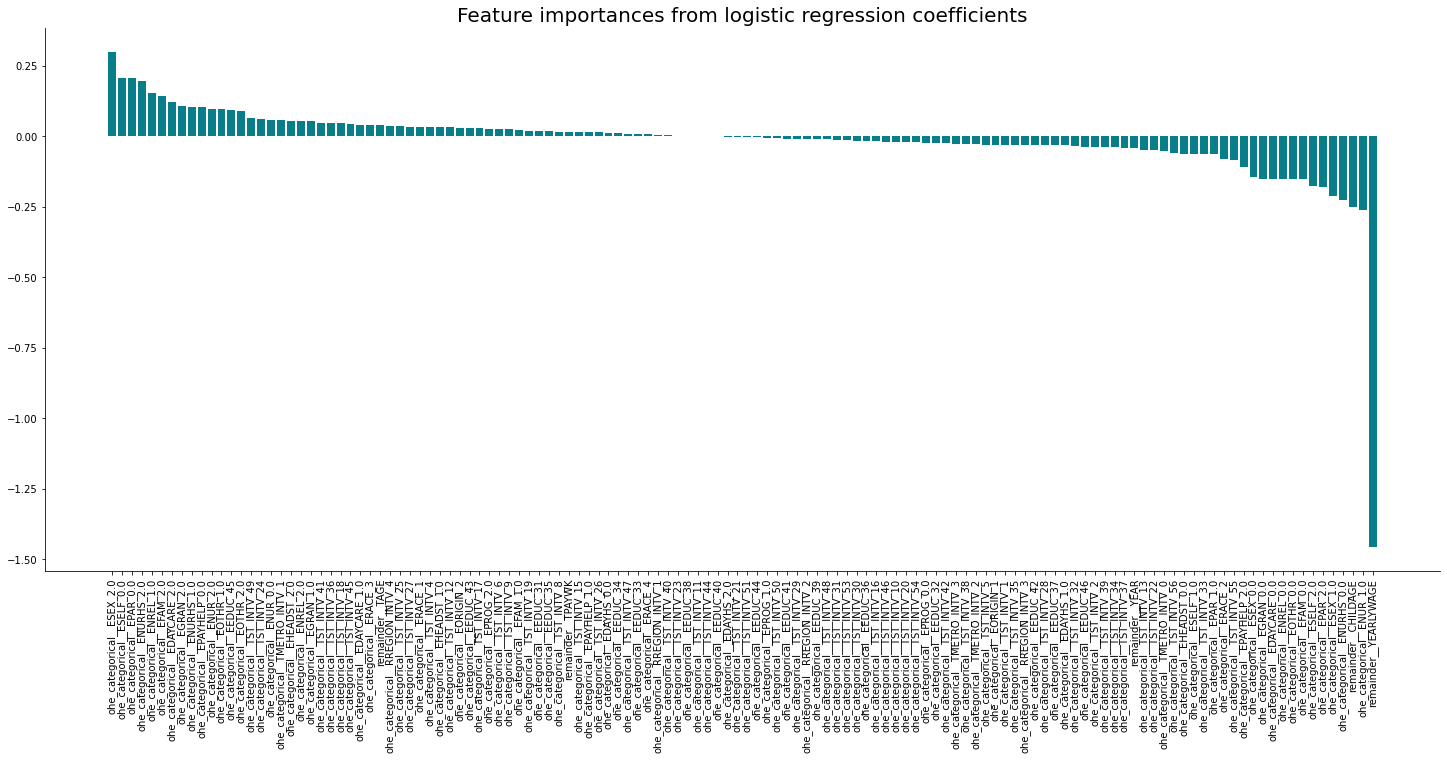

In [122]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 25, 10
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances from logistic regression coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

## Parameter Tuning

We can use grid search to tune the model hyperparameters to attempt to improve our model. Note that this process is quite time consuming. In this case, parameter tuning did not result in model improvements.

In [123]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

In [81]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']
params = dict(log_reg__C=C, log_reg__penalty=penalty, log_reg__solver = ['liblinear'])
ftwo_scorer = make_scorer(fbeta_score, beta=2)

In [82]:
gs_model = GridSearchCV(model, params, cv=5, verbose=2, scoring=ftwo_scorer)

In [83]:
gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END log_reg__C=0.0001, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.4s
[CV] END log_reg__C=0.0001, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.3s
[CV] END log_reg__C=0.0001, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.3s
[CV] END log_reg__C=0.0001, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.3s
[CV] END log_reg__C=0.0001, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.3s
[CV] END log_reg__C=0.0001, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.6s
[CV] END log_reg__C=0.0001, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.6s
[CV] END log_reg__C=0.0001, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.6s
[CV] END log_reg__C=0.0001, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.6s
[CV] END log_reg__C=0.0001, log_reg__penalty=l2, log_reg__solver=liblinear; total 

[CV] END log_reg__C=0.0013894954943731374, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.8s
[CV] END log_reg__C=0.0013894954943731374, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.8s
[CV] END log_reg__C=0.0013894954943731374, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.8s
[CV] END log_reg__C=0.0013894954943731374, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.8s
[CV] END log_reg__C=0.0013894954943731374, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   0.9s
[CV] END log_reg__C=0.0020235896477251557, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.7s
[CV] END log_reg__C=0.0020235896477251557, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   1.1s
[CV] END log_reg__C=0.0020235896477251557, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.5s
[CV] END log_reg__C=0.0020235896477251557, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   0.7s
[CV] END l

[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   1.5s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   9.5s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   2.4s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   2.3s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   1.6s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.4s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.4s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.2s
[CV] END log_reg__C=0.02811768697974228, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.4s
[CV] END log_reg__C=0.028117

[CV] END log_reg__C=0.3906939937054613, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.5s
[CV] END log_reg__C=0.3906939937054613, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=0.3906939937054613, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.9s
[CV] END log_reg__C=0.3906939937054613, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.9s
[CV] END log_reg__C=0.5689866029018293, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  22.6s
[CV] END log_reg__C=0.5689866029018293, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  24.9s
[CV] END log_reg__C=0.5689866029018293, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  22.8s
[CV] END log_reg__C=0.5689866029018293, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  46.0s
[CV] END log_reg__C=0.5689866029018293, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  36.4s
[CV] END log_reg__C=0.568986602901829

[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  16.7s
[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  37.7s
[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.5s
[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=7.9060432109076855, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.9s
[CV] END log_reg__C=11.513953993264458, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  28.1s
[CV] END log_reg__C=11.513953993264458, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  15.3s
[CV] END log_reg__C=11.51395399326445

[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  22.1s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l1, log_reg__solver=liblinear; total time=   1.5s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  22.2s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  14.6s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  27.6s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.5s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=159.98587196060572, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=159.9858719606057

[CV] END log_reg__C=2222.996482526191, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=2222.996482526191, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=2222.996482526191, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   1.9s
[CV] END log_reg__C=3237.45754281764, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  14.7s
[CV] END log_reg__C=3237.45754281764, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  12.3s
[CV] END log_reg__C=3237.45754281764, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  14.1s
[CV] END log_reg__C=3237.45754281764, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  18.4s
[CV] END log_reg__C=3237.45754281764, log_reg__penalty=l1, log_reg__solver=liblinear; total time=  17.0s
[CV] END log_reg__C=3237.45754281764, log_reg__penalty=l2, log_reg__solver=liblinear; total time=   2.0s
[CV] END log_reg__C=3237.45754281764, log_reg__penal

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe_categorical',
                                                                         OneHotEncoder(sparse=False),
                                                                         ['TST_INTV',
                                                                          'RREGION_INTV',
                                                                          'TMETRO_INTV',
                                                                          'ESEX',
                                                                          'ERACE',
                                                                          'EORIGIN',
                                                                          'EEDUC',
                                                                          'EDAYCARE',
                                                                          'EDAYHS',
                                                                          'EFAM',
                                                                          'EGRAN',
                                                                          'EHEADST',
                                                                          'ENREL',
                                                                          'ENUR',
                                                                          'ENURHS',
                                                                          'EOTHR',
                                                                          'EPAR',
                                                                          'ESELF',
                                                                          'EPROG',
                                                                          'EPAYHELP'])])),
                                       ('scal...
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'log_reg__penalty': ['l1', 'l2'],
                         'log_reg__solver': ['liblinear']},
             scoring=make_scorer(fbeta_score, beta=2), verbose=2)

In [84]:
gs_model.best_estimator_.get_params()['log_reg__penalty']

'l2'

In [85]:
gs_model.best_estimator_.get_params()['log_reg__C']

0.0001

In [86]:
gs_model_score = model_evaluation(gs_model, X_test, y_test)

In [87]:
print_model_evaluation('Tuned Logistic Regression Model', gs_model_score)

Tuned Logistic Regression Model evaluation 

Test accuracy: 0.9052
Test precision: 0.5864
Test recall: 0.2733
Test area under precision-recall curve: 0.4239


## Over Sampling Imbalanced Data

Our model recall is low because our data is imbalanced. We can oversample the minority class (people with conflicts between work hours and childcare arrangements) to improve recall. We will randomly oversample so that the ratio of minority to majority class samples is 50%.

### Random Oversampling Model

In [124]:
from imblearn.over_sampling import RandomOverSampler

In [125]:
oversample = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [126]:
model.fit(X_over, y_over)

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_categorical',
                                                  OneHotEncoder(sparse=False),
                                                  ['TST_INTV', 'RREGION_INTV',
                                                   'TMETRO_INTV', 'ESEX',
                                                   'ERACE', 'EORIGIN', 'EEDUC',
                                                   'EDAYCARE', 'EDAYHS', 'EFAM',
                                                   'EGRAN', 'EHEADST', 'ENREL',
                                                   'ENUR', 'ENURHS', 'EOTHR',
                                                   'EPAR', 'ESELF', 'EPROG',
                                                   'EPAYHELP'])])),
                ('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(max_iter=10000, random_state=47))])

In [127]:
model_score = model_evaluation(model, X_test, y_test)

print_model_evaluation('Logistic Regression Model', model_score)

Logistic Regression Model evaluation 

Test accuracy: 0.8635
Test precision: 0.395
Test recall: 0.6086
Test area under precision-recall curve: 0.463


In our oversampled model, the accuracy is a bit worse, which is expected. We have significantly improved the model recall, though.

We can then analyze the feature importance in the oversampled model.

In [128]:
oversampled_importances = pd.DataFrame(data={'Attribute': model['ohe'].get_feature_names_out(), 'Importance': model['log_reg'].coef_[0]})

In [129]:
oversampled_importances = oversampled_importances.sort_values(by='Importance', ascending=False)

In [130]:
oversampled_importances

,Attribute,Importance
61,ohe_categorical__ESEX_2.0,0.300161
107,ohe_categorical__ENURHS_2.0,0.224430
114,ohe_categorical__ESELF_0.0,0.203694
111,ohe_categorical__EPAR_0.0,0.203694
100,ohe_categorical__ENREL_1.0,0.155818
92,ohe_categorical__EFAM_2.0,0.138587
86,ohe_categorical__EDAYCARE_2.0,0.129590
104,ohe_categorical__ENUR_2.0,0.128302
106,ohe_categorical__ENURHS_1.0,0.126185
120,ohe_categorical__EPAYHELP_0.0,0.109562


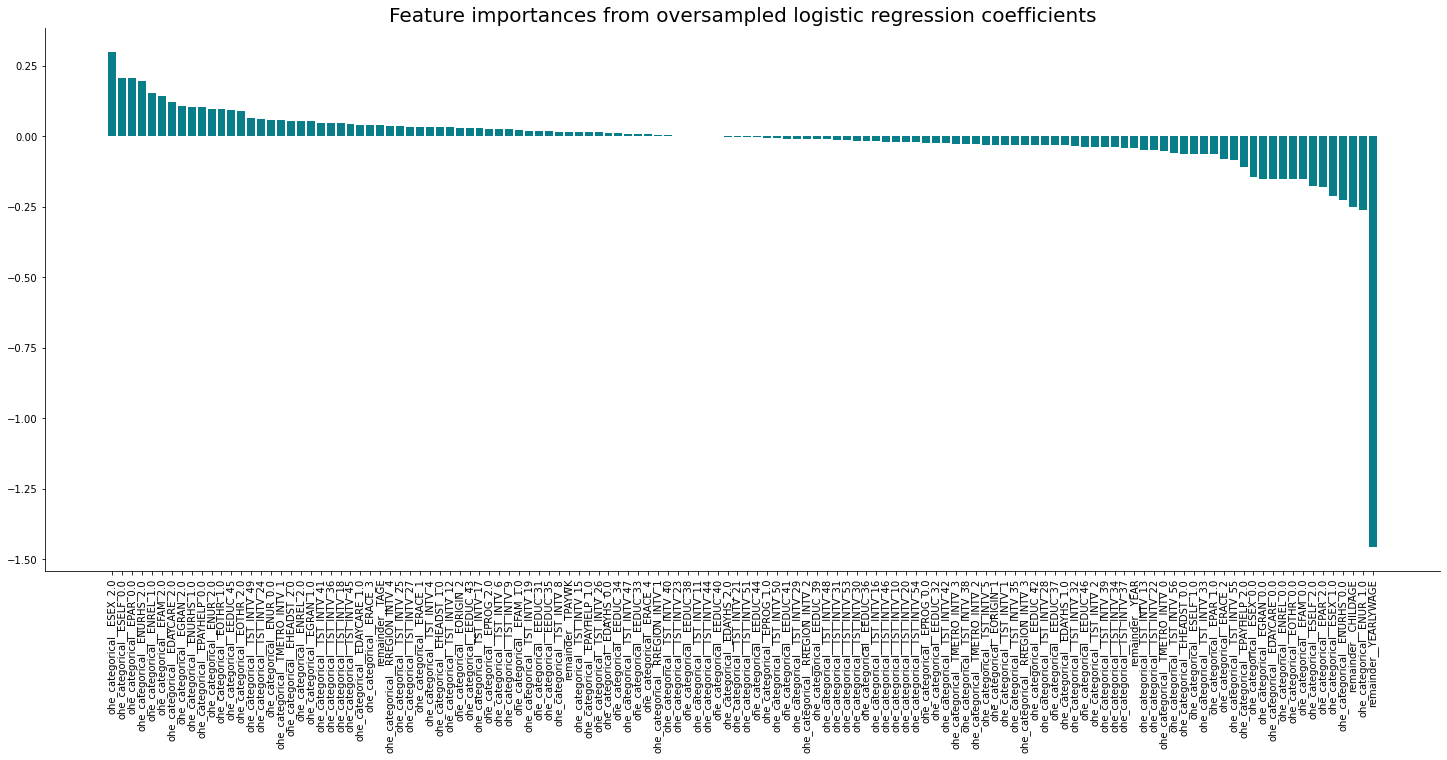

In [132]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances from oversampled logistic regression coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()